# Homework of Week 5 - Extra Credits (Updating the Noise Models Notebook)

# Before we Start

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Circuit and Visualization
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# Aer simulator and noise
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise import pauli_error, thermal_relaxation_error

print("Qiskit version:", qiskit.__version__)
print("Qiskit Aer version:", qiskit_aer.__version__)

Qiskit version: 1.3.2
Qiskit Aer version: 0.17.0


# Noise and Decoherence

We consider a system that generates the Bell state $\ket{\Phi^+}$.

In [32]:
# System Specification
n_qubits = 2
qc = QuantumCircuit(n_qubits)

# Prepare the Bell state
qc.h(0)
for q in range(n_qubits - 1):
    qc.cx(q, q + 1)

# Get the state vector
state = Statevector(qc)
state.draw("latex")

<IPython.core.display.Latex object>

In [33]:
# Measure the qubits
qc.measure_all()
qc.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

## Noiseless Simulation

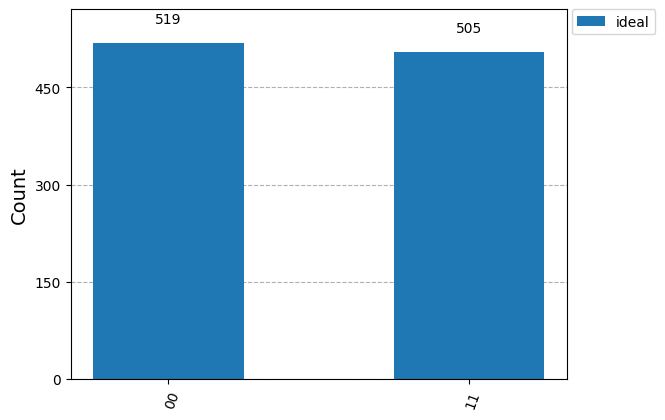

In [34]:
# Ideal Execution on Noise-Free Simulator
sim = AerSimulator()

# Run
job_ideal = sim.run(qc)
result_ideal = job_ideal.result()
counts_ideal = result_ideal.get_counts()

# Plot
plot_histogram(counts_ideal, legend=["ideal"])

# Bit Flip Noise

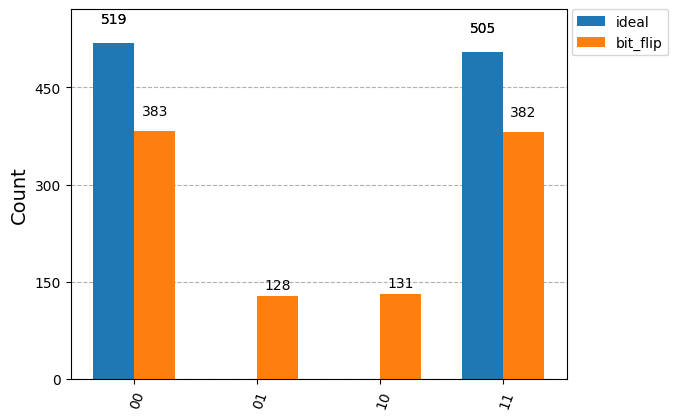

In [ ]:
# Bit-Flip Noise Model
p_reset = 0.03
p_meas = 0.1
p_gate = 0.05

# Create the noise model
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X', p_meas), ('I', 1 - p_meas)])
error_gate = pauli_error([('X', p_gate), ('I', 1 - p_gate)])
error_cx = error_gate.tensor(error_gate)

noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, 'reset')
noise_bit_flip.add_all_qubit_quantum_error(error_meas, 'measure')
noise_bit_flip.add_all_qubit_quantum_error(error_gate, ['h', 'x', 'y', 'z'])
noise_bit_flip.add_all_qubit_quantum_error(error_cx, ['cx'])

# Run noisy simulation
sim_bit = AerSimulator(noise_model=noise_bit_flip,
                       basis_gates=noise_bit_flip.basis_gates)

job_bit = sim_bit.run(qc)
counts_bit = job_bit.result().get_counts()

# Plot comparison
plot_histogram([counts_ideal, counts_bit], legend=["ideal", "bit_flip"])

## Thermal Noise

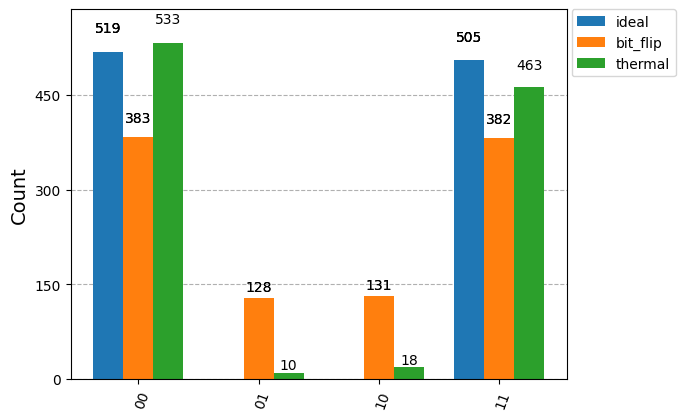

In [ ]:
# Thermal Relaxation Noise Model

# Random T1/T2 times (ns)
T1s = np.random.normal(50e3, 10e3, n_qubits)
T2s = np.minimum(np.random.normal(50e3, 10e3, n_qubits), 2 * T1s)

times = {
    'reset': 1000,
    'measure': 1000,
    'u1': 0,
    'u2': 50,
    'u3': 100,
    'cx': 300,
}

# Build errors per instruction
noise_thermal = NoiseModel()
for idx in range(n_qubits):
    t1, t2 = T1s[idx], T2s[idx]
    # Single-qubit
    noise_thermal.add_quantum_error(
        thermal_relaxation_error(t1, t2, times['reset']), 'reset', [idx]
    )
    noise_thermal.add_quantum_error(
        thermal_relaxation_error(t1, t2, times['measure']), 'measure', [idx]
    )
    for gate in ['u1', 'u2', 'u3']:
        noise_thermal.add_quantum_error(
            thermal_relaxation_error(t1, t2, times[gate]), gate, [idx]
        )

# Two-qubit CX errors
for i in range(n_qubits):
    for j in range(n_qubits):
        err = thermal_relaxation_error(T1s[i], T2s[i], times['cx']).expand(
            thermal_relaxation_error(T1s[j], T2s[j], times['cx'])
        )
        noise_thermal.add_quantum_error(err, 'cx', [i, j])

# Run noisy thermal
sim_therm = AerSimulator(noise_model=noise_thermal,
                         basis_gates=noise_thermal.basis_gates)
job_therm = sim_therm.run(qc)
counts_therm = job_therm.result().get_counts()

# Plot all
plot_histogram([counts_ideal, counts_bit, counts_therm],
               legend=["ideal", "bit_flip", "thermal"])